# Intro to classification

### Outline

1. Introduction to Classification (10 min)
	•	Goal: Introduce classification as a fundamental problem in machine learning.
	•	Key Concepts:
	•	What is classification?
	•	Examples of binary classification problems (e.g., spam vs. non-spam, disease vs. no disease).
	•	Distinction between linear and non-linear classifiers.
	•	Code Snippets/Visualizations:
	•	Generate and visualize a simple 2D dataset with two classes using matplotlib and scikit-learn.datasets.make_classification.

2. Basics of Probability Theory (15 min)
	•	Goal: Introduce key probability concepts relevant to classification.
	•	Key Concepts:
	•	Joint probability ￼, conditional probability ￼, and independence.
	•	Bayes’ Theorem and its intuition.
	•	Example: Given symptoms, what is the probability of having a disease?
	•	Code Snippets/Visualizations:
	•	Define and compute joint/conditional probabilities using NumPy.
	•	Visualize conditional probability using a simple probability table or heatmap.

3. Naïve Bayes Classifier (20 min)
	•	Goal: Introduce the Naïve Bayes model as a simple probabilistic classifier.
	•	Key Concepts:
	•	Bayes’ rule applied to classification.
	•	Naïve assumption: Features are conditionally independent given the class.
	•	Derivation of the log-likelihood form for classification.
	•	Example: Classifying spam emails based on word frequencies.
	•	Code Snippets/Visualizations:
	•	Implement a basic Naïve Bayes classifier on a toy dataset.
	•	Show decision boundaries using matplotlib.contourf.

4. Logistic Regression (20 min)
	•	Goal: Introduce logistic regression as a linear classifier based on probability modeling.
	•	Key Concepts:
	•	Logistic function: ￼.
	•	Log-odds and interpretation of model parameters.
	•	Optimization via gradient descent.
	•	Comparison with Naïve Bayes.
	•	Code Snippets/Visualizations:
	•	Implement logistic regression using scikit-learn or torch.
	•	Visualize the sigmoid function and decision boundary.

5. Summary and Discussion (10 min)
	•	Key Takeaways:
	•	Classification as probability estimation.
	•	Comparison of Naïve Bayes and logistic regression.
	•	Limitations of linear classifiers and transition to non-linear methods.
	•	Interactive Elements:
	•	Small quiz: Given some data, which classifier would work better?
	•	Discussion on real-world applications.

Suggested Code Elements
	•	Data Visualization: Use matplotlib to show decision boundaries and probabilities.
	•	Probability Computation: Use NumPy to compute conditional probabilities.
	•	Classifier Implementation: Implement Naïve Bayes and logistic regression using scikit-learn.
	•	Optimization: Demonstrate gradient descent using torch (optional).

Would you like any refinements, such as more focus on derivations or more interactive elements?

### Introduction
So far, we've been focussing on *regression* tasks in machine learning, in which the goal is to predict the value of a  continuous target. In this lesson, we'll shift our focus to *classification*, in which the goal is to predict the value of a discrete target variable.

Thus, we will be working within the following set-up: We are given a labelled (training) dataset with the following specifications:
- The dataset consists of $m$ instances.
- There are $n$ features $X_1,\dotsc,X_n$ (continuous or categorical) associated with each instance, each represented by a feature vector $\mathbf{x}_i \in \mathbb{R}^m$. 
- There is a target variable $Y$ that is categorical, and can take values in a finite set of *classes* $C = \{c_1,\dotsc,c_k\}$. This is represented by a target vector $\mathbf{y} \in C^m$. 
The goal of the classification model (referred to as a *classifier*) is to learn a ground truth function
\begin{equation*}
    f: \mathbb{R}^n \to C
\end{equation*}
which outputs a class label given a particular combination of values of the features. 

When $k=2$ (i.e. $C$ consists of only two classes), we have a *binary classification* problem. Binary targets can always be interpreted as yes/no answers to a question, such as "Is this email spam?" or "Does this patient have a particular disease?", or "Will this customer buy this product?".

When $k>2$, we have a *multi-class classification* problem.  Multi-class targets can similarly be interpreted as answers to questions such as "What type of animal is in this image?" or "What is the genre of this song?", or (in the case of large language models) "What is the next word in this sentence?".

### A visual perspective
Classification can be understood quite intuitively from a visual perspective. Namely, let's associate a color to each of the possible classes $c_1,\dotsc,c_k$. Then, we can visualize the dataset as a collection of $m$ points in the feature space $\mathbb{R}^n$. The goal of a classifier is to partition the feature space into $k$ regions $R_1,\dotsc,R_k$, each corresponding to a color $c_i$. To predict the class of a given a data point $\mathbf{r} \in \mathbb{R}^n$, the classifier simply checks which of these regions $R_i$ the point lies in, and it predicts the class to be the corresponding color $c_i$. 

The boundaries that separate the various regions in $\mathbb{R}^n$ are called **decision boundaries**, so named because the decision to assign a particular class changes when one crosses the boundary from one region to another. Classifiers are sometimes referred to as *linear classifiers*, *quadratic classifiers*, and so on, depending on the nature/curvature of these decision boundaries. 

The simplest to understand are the linear classifiers, which use decision boundaries that are straight lines/planes, etc. We will cover two well-known linear classifiers:
1. **Perceptrons**: The simplest possible linear classifier for binary classification that uses a step function to make predictions. These are the building blocks of neural networks.
2. **Logistic regression**: A linear classifier that uses a logistic function to make predictions. These are one of the most widely used classifiers in practice, and the multi-class version of logistic regression is used as the last step in many neural network architectures.

Below, we visualize a simple binary classification problem with two features, and the decision boundary of a logistic regression classifier. 

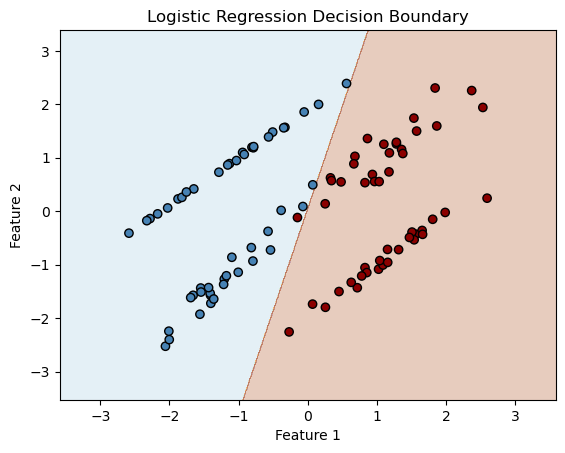

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

# Generate synthetic data
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=42)
colors = ['darkred' if label == 1 else 'steelblue' for label in y]

# Fit logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Create a mesh to plot the decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict probabilities for each point in the mesh
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary and data points
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolors='k', marker='o')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Logistic Regression Decision Boundary')
plt.show()

We will discuss perceptrons and logistic regression in detail in the next two lessons. For this class, the goal will instead be to develop some basics of probability theory that will be useful for understanding these classifiers. To that end, we turn our attention to the concept of probabilistic classifiers. 

### Probabilistic Classifiers

A probabilistic classifier, also known as a **soft classifier**, is a type of classifier that outputs not just a class label for each input data point, but also a probability distribution over all possible class labels. This means that for each input, the classifier provides the probabilities that the input belongs to each of the possible classes; these are called **predicted probabilities**.

Given the output of a soft classifier, one can convert it into a **hard classifier** (which is one which predicts exactly one class label per instance) by simply taking the class with the highest probability. For example, if a soft classifier outputs the probabilities $P(c_1 | \mathbf{x}) = 0.7$, $P(c_2 | \mathbf{x}) = 0.2$, and $P(c_3 | \mathbf{x}) = 0.1$, then the hard classifier would predict class $c_1$ for the input $\mathbf{x}$. In some cases, one may want to use a different **decision threshold** for the probabilities, and classify an input as belonging to a certain class only if the probability exceeds a specific threshold. For example, one may want to classify an input as class $c_1$ only if $P(c_1 | \mathbf{x}) > 0.8$. (This notation will be explained below.)

Key characteristics of probabilistic classifiers include:

1. **Probability Distribution**: They provide a probability distribution over all classes, which sums to 1.
2. **Confidence Scores**: The probabilities can be interpreted as confidence scores, indicating how confident the classifier is in its predictions.
3. **Threshold Flexibility**: They allow for flexible decision thresholds; that is, you can classify an input as belonging to a certain class only if the probability exceeds a specific threshold.
4. **Uncertainty Quantification**: They enable the quantification of uncertainty in predictions, which is useful in many applications where understanding the uncertainty is important.

Our focus in this lesson will be on the **Naïve Bayes classifier**, which is a probabilistic classifier based on Bayes' theorem. First, let's introduce some basic concepts of probability theory that will be useful for understanding the Naïve Bayes classifier.

## Probability theory speedrun
In this section, we will cover some key concepts in probability theory that are relevant to classification tasks.

### 1. Probability spaces 
A probability space consists of a set of possible outcomes $\Omega$ (called the *sample space*), together with a probability measure $P$ that assigns a probability to each *event* (i.e. subset of $\Omega$). The probability measure must satisfy the following properties:
    - $P(A) \geq 0$ for all events $A \subseteq \Omega$.
    - $P(\Omega) = 1$.
    - If $A_1, A_2, \dotsc$ are disjoint events (i.e. distinct subsets), then $P\left(\bigcup_i A_i\right) = \sum_i P(A_i)$.
In the context of ML, probability spaces arise naturally when we consider the possible values of a variable in a dataset. In these cases, the sample space is the set of all possible values that the variable can take (which we previously called the *support* of the variable), and the probability measure assigns a probability to each possible subset of values. 

Moreover, we saw that this measure arises naturally by constructing a suitable proabability function, which takes on two guises depending on whether the variable is continuous or discrete:
- In the discrete case, we have a probability mass function (PMF) $p_X: \Omega \to [0,1]$, which gives the probability that the random variable $X$ takes on the value $x$ (i,e, $p_X(x) = P(X=x)$). For a general event $S \subset \Omega$, the probability is given by $$P(S) = P(X \in S) = \sum_{x \in S} p_X(x).$$
- In the continuous case, we have a probability density function (PDF) $f_X: \Omega \to [0,\infty)$, which gives the density of the random variable $X$ at the value $x$. (Recall that the PDF can be understood as smoothed version of a histogram.) For a general event $S \subset \Omega$, the probability is given by $P(S) = P(X \in S) = \int_S f_X(x) dx.$$

### 2. Joint probabilities
If we have two variables $X_1$ and $X_2$, with sample spaces $\Omega_1$ and $\Omega_2$, then we may wish to consider the probability of both variables taking on particular values simultaneously. That is:
- We first create a new sample space $\Omega_1 \times \Omega_2$, which consists of all possible pairs $(x_1, x_2)$, where $x_1 \in \Omega_1$ and $x_2 \in \Omega_2$.
- Then, for any event $S \subset \Omega_1 \times \Omega_2$, we define the joint probability $P(S)$ as the probability that both $X_1$ and $X_2$ take on values in $S$:
$$P(S) = P((X_1, X_2) \in S).$$
Joint probabilities for more than two distributions are defined similarly.

A probability distribution for a single variable is sometimes called the **marginal distribution** of that variable. This can be visualized as a histogram or a curve, with the $x$-axis representing the sample space $\Omega$, and the $y$-values representing the probabilities or densities. In either case, the total area under the curve (or of the histogram bins) must equal 1.

For two variables, the joint distribution can be visualized as a 3D surface (or histogram with 3D pillars), with the $x$- and $y$-axes representing the sample spaces $\Omega_1$ and $\Omega_2$, and the $z$-axis representing the joint probabilities. This time, the  total *volume* under the surface (or of the histogram pillars) must equal 1. Let's illustrate this by visualizing the joint distribution of two discrete variables from the `car_evaluation` dataset.

In [4]:
# import libraries
import numpy as np
import pandas as pd

cars = pd.read_csv('../data/classification/car_evaluation/train.csv')
vars = pd.read_csv('../data/classification/car_evaluation/data_description.csv')
vars = vars[['new_col_name', 'name', 'type', 'role']]
vars

,new_col_name,name,type,role
0,X1,buying,Categorical,Feature
1,X2,maint,Categorical,Feature
2,X3,doors,Categorical,Feature
3,X4,persons,Categorical,Feature
4,X5,lug_boot,Categorical,Feature
5,X6,safety,Categorical,Feature
6,Y,class,Categorical,Target


In [17]:
# check the values of X1 and Y
print('X1 values:',cars['X1'].unique().tolist())
print('Y  values:',cars['Y'].unique().tolist())

X1 values: ['med', 'low', 'vhigh', 'high']
Y  values: ['acc', 'unacc', 'good', 'vgood']


In [23]:
# encode categorical variables X1 and Y with integers
cars['X1'].replace({'vhigh': 3, 'high': 2, 'med': 1, 'low': 0}, inplace=True)
cars['Y'].replace({'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3}, inplace=True)
cars.head()

,X1,X2,X3,X4,X5,X6,Y
0,2,med,3,4,med,med,1
1,2,high,3,2,small,med,0
2,1,high,5more,more,small,med,1
3,2,low,2,4,med,high,2
4,4,low,3,2,small,high,0


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

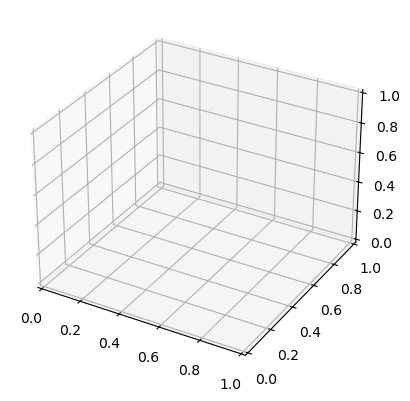

In [5]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract X1 and Y values
X1 = cars['X1']
Y = cars['Y']

# Create a histogram in 3D
hist, xedges, yedges = np.histogram2d(X1, Y, bins=30)

# Construct arrays for the anchor positions of the bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color='b', alpha=0.7)

# Set labels
ax.set_xlabel('X1')
ax.set_ylabel('Y')
ax.set_zlabel('Frequency')

plt.title('3D Joint Distribution of X1 and Y')
plt.show()

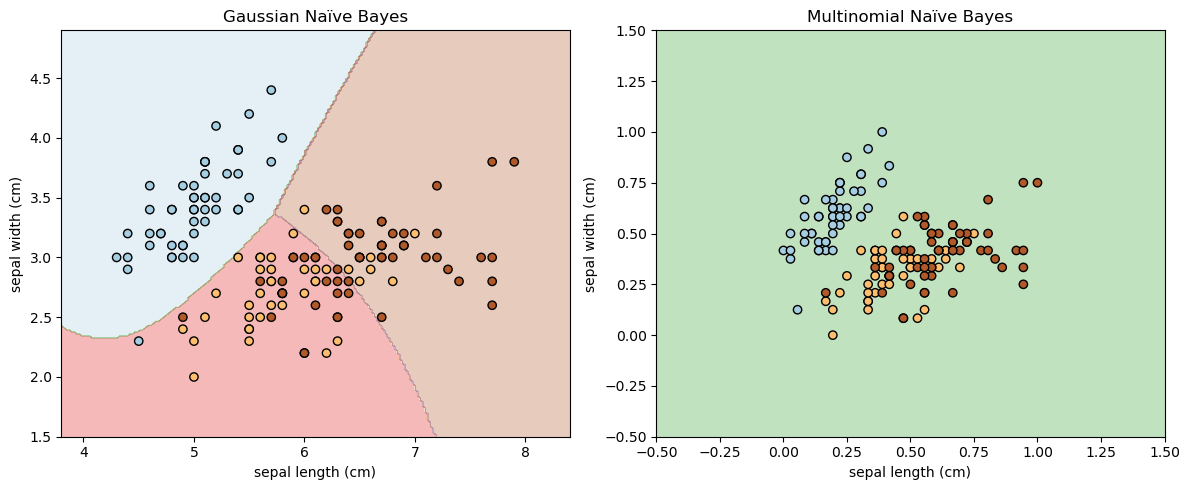

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import MinMaxScaler

# Load Iris dataset
iris = datasets.load_iris()
X = iris.data[:, :2]  # Select only two features for visualization
y = iris.target       # Three class labels (0, 1, 2)

# Train Gaussian Naïve Bayes
gnb = GaussianNB()
gnb.fit(X, y)

# Train Multinomial Naïve Bayes (Requires Non-Negative Features)
scaler = MinMaxScaler()  # Normalize feature values to non-negative range
X_scaled = scaler.fit_transform(X)  # Required for MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_scaled, y)

# Function to plot decision boundaries
def plot_decision_boundary(model, X, y, title, scaler=None):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Preprocess the grid if using MultinomialNB
    grid_data = np.c_[xx.ravel(), yy.ravel()]
    if scaler:
        grid_data = scaler.transform(grid_data)
    
    Z = model.predict(grid_data)
    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", cmap=plt.cm.Paired)
    plt.xlabel(iris.feature_names[0])
    plt.ylabel(iris.feature_names[1])
    plt.title(title)

# Plot decision boundaries for GaussianNB and MultinomialNB
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_decision_boundary(gnb, X, y, "Gaussian Naïve Bayes")

plt.subplot(1, 2, 2)
plot_decision_boundary(mnb, X_scaled, y, "Multinomial Naïve Bayes", scaler)

plt.tight_layout()
plt.show()

In [2]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import make_pipeline

# Sample text dataset
texts = [
    "I love programming in Python",
    "Python is great for machine learning",
    "I hate bugs in my code",
    "Debugging is frustrating but rewarding",
    "Machine learning is fascinating",
    "I enjoy solving coding challenges",
    "Syntax errors are annoying",
]

# Corresponding labels (1 = positive, 0 = negative)
labels = np.array([1, 1, 0, 0, 1, 1, 0])

# MultinomialNB: Uses raw word counts as features
vectorizer_mnb = CountVectorizer(binary=False)  # Keep word counts
X_mnb = vectorizer_mnb.fit_transform(texts)
mnb = MultinomialNB()
mnb.fit(X_mnb, labels)

# BernoulliNB: Uses binary presence/absence of words
vectorizer_bnb = CountVectorizer(binary=True)  # Convert counts to binary
X_bnb = vectorizer_bnb.fit_transform(texts)
bnb = BernoulliNB()
bnb.fit(X_bnb, labels)

# Test on a new sentence
test_text = ["Python debugging is fun but sometimes annoying"]

# Transform test text using both vectorizers
X_test_mnb = vectorizer_mnb.transform(test_text)
X_test_bnb = vectorizer_bnb.transform(test_text)

# Predict using both models
mnb_prediction = mnb.predict(X_test_mnb)
bnb_prediction = bnb.predict(X_test_bnb)

# Print predictions
print(f"MultinomialNB Prediction: {'Positive' if mnb_prediction[0] == 1 else 'Negative'}")
print(f"BernoulliNB Prediction: {'Positive' if bnb_prediction[0] == 1 else 'Negative'}")

MultinomialNB Prediction: Negative
BernoulliNB Prediction: Negative


Here’s a code example comparing Multinomial Naïve Bayes (MNB) and Bernoulli Naïve Bayes (BNB) using a simple text classification task with scikit-learn.

What This Code Does
	1.	Creates a toy text dataset (a few sample sentences categorized into two classes).
	2.	Converts text into numerical features using CountVectorizer (for MultinomialNB) and TfidfVectorizer (for BernoulliNB with binary features).
	3.	Trains and evaluates both classifiers on the dataset.
	4.	Compares their behavior on binary vs. count-based features.

Expected Output

Since MultinomialNB relies on word counts, and BernoulliNB focuses on word presence, their predictions may differ. For example:

MultinomialNB Prediction: Positive
BernoulliNB Prediction: Negative

This happens because:
	•	MultinomialNB considers the frequency of words (e.g., “Python” and “debugging” appearing more often in positive examples).
	•	BernoulliNB only considers whether words appear at all, ignoring how many times they appear.

Key Takeaways
	•	MultinomialNB is sensitive to word frequency, making it useful for text classification where word counts matter (e.g., spam detection).
	•	BernoulliNB is binary (word presence/absence matters, not frequency), making it better for shorter texts or cases where frequent words don’t add extra meaning.